<a href="https://colab.research.google.com/github/Torm198/FingerprintGAN/blob/main/FingerprintGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Projeto tem como objetivo gerar um discriminador de digitais falsas através de uma GAN

In [ ]:
import numpy as np
import os
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose,BatchNormalization
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Digitais2.zip" -d "/content/Digitais2"

Inicialmente vamos importar o banco de digitais

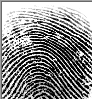

In [ ]:
def imp_imagem(diretorio):
    arquivos = os.listdir(diretorio)
    dados = []
    for imagem in arquivos:
        imp = img_to_array(load_img(diretorio + imagem, color_mode='grayscale'))
        if np.shape(imp) == (103, 96, 1):
            dados.append(imp[7:, :, :] / 255)
    dados = np.asarray(dados)
    return dados


Banco_real = imp_imagem('/content/Digitais2/')



Abaixo segue a estrutura do modelo do Discriminador

In [ ]:
discriminador = Sequential()
discriminador.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(96, 96, 1)))
discriminador.add(LeakyReLU(alpha=0.2))
discriminador.add(Dropout(0.4))
discriminador.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
discriminador.add(LeakyReLU(alpha=0.2))
discriminador.add(Dropout(0.4))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation='sigmoid'))
opt = Adam(lr=0.0002, beta_1=0.5)
discriminador.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminador.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0

Abaixo segue a arquitetura do gerador, note que não vamos compilar ele


In [ ]:
#######################################
gerador = Sequential()
# gerando uma imagem 6x6
gerador.add(Dense(128 * 6 * 6, input_dim=200))
gerador.add(LeakyReLU(alpha=0.2))
gerador.add(BatchNormalization(momentum=0.8))
gerador.add(Reshape((6, 6, 128)))

# upsample para 24x24
gerador.add(Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same'))
gerador.add(LeakyReLU(alpha=0.2))
gerador.add(BatchNormalization(momentum=0.8))

# upsample para 96x96
gerador.add(Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same'))
gerador.add(LeakyReLU(alpha=0.2))
gerador.add(BatchNormalization(momentum=0.8))
# layer de saida
gerador.add(Conv2D(1, (6, 6), activation="sigmoid", padding="same"))
gerador.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4608)              926208    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4608)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4608)              18432     
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)      

Para poder treinar o gerador precisamos atualizar os seus pesos baseado no resultado da rede discriminadora que por sua vez não sofrerá alterações nesse processo

In [ ]:
######################################

def cria_gan(modelo_g=gerador, modelo_d=discriminador):
    global opt
    modelo_d.trainable = False
    GAN = Sequential()
    GAN.add(modelo_g)
    GAN.add(modelo_d)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    return GAN


GAN = cria_gan()

GAN.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 96, 96, 1)         1474817   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 74433     
Total params: 1,549,250
Trainable params: 1,465,089
Non-trainable params: 84,161
_________________________________________________________________


Abaixo seguem funções de apoio utilizadas no treinamento da rede

In [ ]:
# função para gerar uma amostra de imagens falsas
def imagens_falsas(gen, n):
  # vetor aleatorio de entrada
    x = np.random.randn(n * 200)
  # adequando o formato ao modelo
    x = np.reshape(x, (n, 200))
  # utilizando o predict para gerar n imagens falsas 
    saida = gen.predict(x)
  # criando a label de falsa
    label = np.zeros((n, 1))
    return saida, label

# função para gerar uma amostra de imagens falsas
def amostra_imagens_reais(dados, n):
   # amostrando aleatóriamente fotos do banco de treino
    ix = np.random.randint(0, dados.shape[0], n)
    X = dados[ix]
  # criando a label de imagem verdadeira
    y = np.ones((n, 1))
    return X, y


def salvar_imagem(gen, epoch):
    ex = imagens_falsas(gen, 1)
    plt.title('Epoch ' + str(epoch + 1))
    plt.axis('off')

    plt.imshow(ex[0][0, :, :, 0], cmap='gray')
    plt.savefig(f'/content/Epochs/Epoch{epoch + 1:03}.png')
    plt.close()
     




Abaixo segue o loop utilizado para treinar a rede, como queremos treinar

In [ ]:
n_batch = 200
n_epochs = 300

dloss_list = [0.0] * n_epochs
dacc_list = [0.0] * n_epochs
gloss_list = [0.0] * n_epochs
bat_por_epo = int(2000 / n_batch)
meia_amostra = int(n_batch / 2)

for i in range(n_epochs):
    for j in range(bat_por_epo):
      # gerando amostras
        x_real, y_real = amostra_imagens_reais(Banco_real, meia_amostra)
        x_falso, y_falso = imagens_falsas(gerador, meia_amostra)
        X, y = np.vstack((x_real, x_falso)), np.vstack((y_real, y_falso))
        # treinando discriminador
        d_loss, d_acc = discriminador.train_on_batch(X, y)
        semente = np.random.randn(n_batch * 200).reshape(n_batch, 200)
        y_semente = np.ones((n_batch, 1))
        # treinando o gerador
        g_loss = GAN.train_on_batch(semente, y_semente)
    # salvando dados relevantes
    gloss_list[i] = g_loss
    dloss_list[i] = d_loss
    dacc_list[i] = d_acc
    if (i + 1) % 10 == 0:
        salvar_imagem(gerador, i)



Criando gráficos de acurácia e perda

In [ ]:
label_x = range(1, n_epochs+1)
plt.plot(label_x, gloss_list,label='Loss Gerador')
plt.plot(label_x, dloss_list,label='Loss Discriminador')
plt.title('Evolução da Perda do Modelo')
plt.legend()
plt.savefig('modelo2 loss.png')
plt.close()
files.download("modelo2 loss.png") 
plt.plot(label_x, dacc_list)
plt.title('Acurácia do Discriminante')
plt.savefig('modelo2 acc.png')
files.download("modelo2 acc.png") 
plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Demonstração gráfica da arquitetura da rede

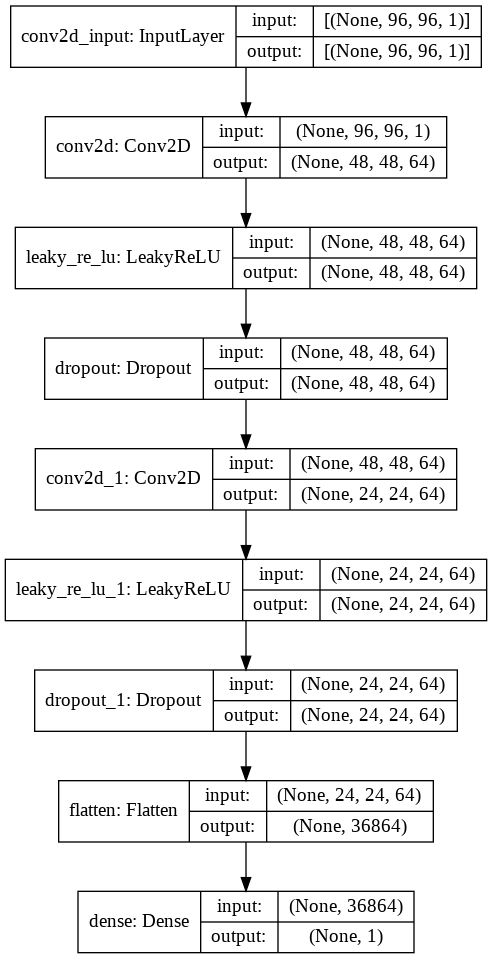

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(discriminador, to_file='discriminante_plot.png',
           show_shapes=True, show_layer_names=True)



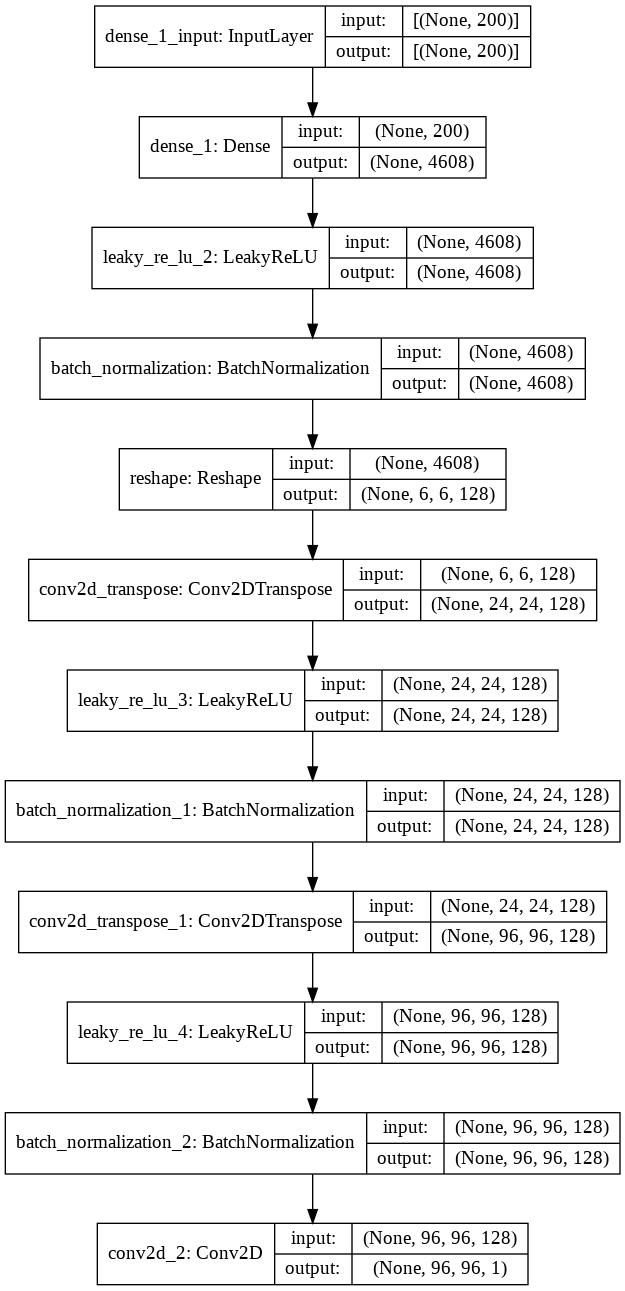

In [ ]:
plot_model(gerador, to_file='gerador_plot.png', show_shapes=True, show_layer_names=True)

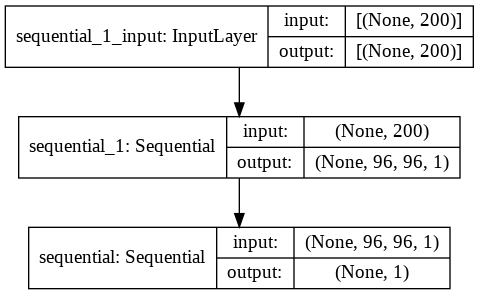

In [ ]:
plot_model(GAN, to_file='GAN_plot.png', show_shapes=True, show_layer_names=True)